<a href="https://colab.research.google.com/github/EricW1118/NLP/blob/main/LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install libs needed
!pip3 install torch 
!pip3 install torchvision
!pip3 install torchtext
!pip3 install pandas
!pip3 install nltk
!pip3 install -U scikit-learn scipy matplotlib
!pip3 install spacy
!pip3 install seaborn
!pip3 install keras_preprocessing

In [ ]:
# Import libs
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import string
import seaborn as sns
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
# Stopwords removal
def stopword_removal(row):
    text = row['text']
    row['text'] = remove_stopwords(text)
    return row

# After stopwords and puntuations removal, there may be some empty row in text, replace this row with np.naN
# Then we can apply dropna to eliminate these rows
def removeEmpty(row):
    text = str(row['text'])
    if text.isspace() or len(text) <= 0:
        row['text'] = np.NaN
    return row
  
# Load the csv from the path given in the parameter
# Apply different processing methods defined above
def load_csv(file_path):
    df = pd.read_csv(file_path)
    df.columns = ["id","title","text","label"]
    df.drop(labels=['id','title'], axis='columns', inplace=True)
    df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
    df.dropna(subset = ["text"], inplace=True)
    df = df.apply(stopword_removal, axis=1)
    df = df.apply(removeEmpty, axis=1)
    df.dropna(subset = ["text"], inplace=True)
    return df

In [ ]:
# Only if you are using Google Colab, you need to mount the Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Use the function defined above to load the csv data
# df = load_csv('WELFake_Dataset.csv')
df = load_csv('/content/gdrive/My Drive/NLP/WELFake_Dataset.csv')

<ipython-input-3-33c76519a373>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [ ]:
# Print the data summary 
df.info()

# Print some rows of the dataset
print(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71349 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    71349 non-null  object
 1   label   71349 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
                                                    text  label
0      comment expected barack obama members fyf911 f...      1
1                                     post votes hillary      1
2      demonstrators gathered night exercising consti...      1
3      dozen politically active pastors came private ...      0
4      rs 28 sarmat missile dubbed satan 2 replace ss...      1
...                                                  ...    ...
72129  washington reuters hackers believed working ru...      0
72130  know fantasyland republicans questioned citize...      1
72131  migrants refuse leave train refugee camp hunga...      0
72132  mexico city reuters donald trump s combative s...  

In [ ]:
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 64

# vectorize the text samples into a 2D integer tensor 
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


# tokenizing sentences into words 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# using fit_on_texts method assigning values to particular words
tokenizer.fit_on_texts(df['text'])
# texts_to_sequences method is used to give particular integer values to word
sequences = tokenizer.texts_to_sequences(df['text'])

# calculating word_index
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
# padding data to the same length for each samples
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', df['label'].shape)

Found 242504 unique tokens.
Shape of data tensor: (71349, 700)
Shape of label tensor: (71349,)


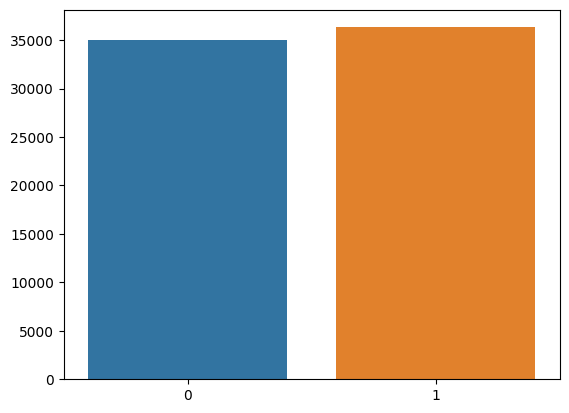

In [ ]:
# Check if the data is balanced between all the classes
data_count = df['label'].value_counts()
sns.barplot(x=np.array([1,0]),y=data_count.values)
plt.show()

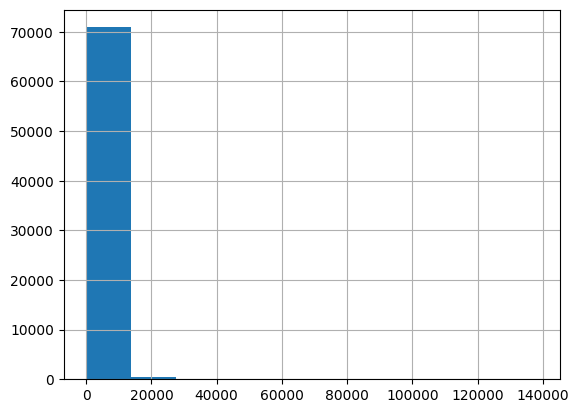

count     71349.000000
mean       2166.011717
std        2399.967844
min           1.000000
25%         940.000000
50%        1617.000000
75%        2702.000000
max      138188.000000
dtype: float64

In [ ]:
# Plot the length distribution of sentences of the dataset
rev_len = [len(i) for i in  df['text']]
pd.Series(rev_len).hist()
plt.show()

# Summarize the sentence length distribution
pd.Series(rev_len).describe()

In [ ]:
# Calculate the number of rows with lable 1 and 0
df_zero_X, df_one_X= data[df['label'] == 0], data[df['label'] ==1]
df_zero_y, df_one_y = np.array(df[df['label'] == 0]['label']), np.array(df[df['label'] == 1]['label'])

print('length of sentences with label zero : %4d' % (len(df_zero_X)))
print('length of sentences with label one: %4d' % (len(df_one_X)))

print('---------------------------------------------------------------')
print('length of label zero : %4d' % (len(df_zero_y)))
print('length of label one: %4d' % (len(df_one_y)))

length of sentences with label zero : 35026
length of sentences with label one: 36323
---------------------------------------------------------------
length of label zero : 35026
length of label one: 36323


In [ ]:
# Calculate 70% of the number of class 0 and class 1
# Then take the smaller one 
train_length = int(min(len(df_zero_X) * 0.7, len(df_one_X) * 0.7))
print('length of each train set: %4d ' % (train_length))

# Randomly pick the number calculated above of rows from class 1 and class 0
# This operation makes sure we take the same number of rows from each class
# Make sure our training dataset is balanced
zero_train, zero_test, zero_train_y, zero_test_y = train_test_split(df_zero_X, df_zero_y, train_size=train_length, shuffle=True, random_state=36)
one_train, one_test, one_train_y, one_test_y = train_test_split(df_one_X,df_one_y, train_size=train_length, shuffle=True, random_state=36)

train_X, train_y = np.concatenate([zero_train,one_train]), np.concatenate([zero_train_y,one_train_y])
test_X, test_y = np.concatenate([zero_test,one_test]), np.concatenate([zero_test_y,one_test_y])


length of each train set: 24518 


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(test_X), torch.from_numpy(test_y))

# dataloaders 
batch_size = 82

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

In [ ]:
# is_cuda = not torch.cuda.is_available
is_cuda = torch.cuda.is_available
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")

    print("GPU is available")
    
else:
    device = torch.device("cpu")
    print("GPU is not available, CPU used")

GPU is available


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional = False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sig = nn.Sigmoid()

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.num_layers,batch_size,self.hidden_size)).to(device)
        c0 = torch.zeros((self.num_layers,batch_size,self.hidden_size)).to(device)
        hidden = (h0,c0)
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.size(0)

        embedded = self.embedding(x)

        out, hidden = self.lstm(embedded, hidden)
        
        # Extract the last timestep's output
        out = out[:, -1, :]

        out = self.dropout(out)

        out = self.fc(out)

        out = self.sig(out)

         # Reshape to be batch_size first
        out = out.view(batch_size, -1)

        out = out[:, -1] # get last batch of labels
      
        return out, hidden


In [ ]:
# Define the model
embedding_dim = 70
num_classes = 1
vocab_size = MAX_NUM_WORDS + 1 #extra 1 for padding
hidden_size = 128
num_layers = 10

# Create the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_size, num_layers, num_classes)
model.to(device)

LSTMClassifier(
  (embedding): Embedding(1001, 70)
  (lstm): LSTM(70, 128, num_layers=10, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [ ]:
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 1361463


In [ ]:
import torch.optim as optim

# function to predict accuracy
def num_of_acc(pred,label):
    # print(predicted.shape, label.shape)
    # pred = torch.round(pred.squeeze())
    # return torch.sum(ropredicted == label.squeeze()).item()
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

def acc_of(model,dataloader):
    model.eval()
    num_sample = 0
    accnum = 0
    for X, y in dataloader:
      num_sample += len(X)
      X, y = X.to(device), y.to(device)
      # print(X.shape, y.shape)
      outputs = model(X)
      batch_acc = num_of_acc(outputs,y)
      accnum += batch_acc
    return (accnum / num_sample)


# criterion = nn.CrossEntropyLoss()  # Assuming your classification task has multiple classes
criterion = nn.BCELoss()
# criterion = nn.MultiMarginLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00003)  # Adjust the learning rate as needed
num_epochs = 100  # Define the number of training epochs
optimizer = optim.NAdam(model.parameters(), lr=0.001) 
clip = 5

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    train_acc = 0.0
    num_sample = 0
    hidden = model.init_hidden(train_loader.batch_size)
    for i ,(X, y) in enumerate(train_loader):
        num_sample += len(X)
        X, y = X.to(device), y.to(device)

        hidden = tuple([each.data for each in hidden])

        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs, hidden = model(X, hidden)
        # print(outputs.shape, y.shape)
        batch_acc = num_of_acc(outputs,y)
        train_acc += batch_acc
        loss = criterion(outputs.squeeze(), y.float())
        # Perform backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    # Print the loss for monitoring the training progress
    val_acc = acc_of(model, valid_loader)
    print('Epoch: %5d, Loss: %.5f, train_acc: %.5f, val_acc: %.5f' % (epoch + 1, loss.item(), train_acc / num_sample, val_acc))

TypeError: ignored

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
def plot_auc_roc(model,valid_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in valid_loader :
            inputs = inputs.to(device)
            output = model(inputs)

            output = (output > threshold).int()
            _, output = torch.max(output, dim = 1)
            # print(output)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    print('AUC ROC : %f ' % (roc_auc))
    print('----------------------------------------------------------')
    
    plt.title('AUC ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
  
plot_auc_roc(model, train_loader) 

plot_auc_roc(model, valid_loader) 